# very initial sanity check
* nervous about subjectivity of xspec checking, running a small sample, qpo present test with random forest. only unambiguous sources included. 

## takeaways 
* plot different qpo pairs as same color instead of flattening? 

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error as mse_score
from sklearn.metrics import median_absolute_error as mae_score
from sklearn.metrics import accuracy_score as acc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.multioutput import RegressorChain


plt.style.use('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/misc/stolen_science.mplstyle?token=GHSAT0AAAAAABP54PQO2X2VXMNS256IWOBOYRNCFBA')

rs = 4

qpo_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/code/xspec_related/better-organization/analysis-routines/qpo_data_aggregation/results/pre-steiner-compiled.csv?token=GHSAT0AAAAAABOGNQ24QSUKKTOMTUVHWLRSYRNBDNQ')

In [4]:
# methods

def norm(x, min, max): 
    return (x - min) / (max - min)

In [3]:
mask = np.where(qpo_df['num_qpos']!='flagged')
qpo_df = qpo_df.iloc[mask]
mask = np.where(np.array(qpo_df['num_qpos']).astype(int)>0)
qpo_df = qpo_df.iloc[mask]

spectral_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/2022/wrangled_nthcomp_spectral_data.csv?token=GHSAT0AAAAAABP54PQOHURDC77E7FJ7DAQKYRNBRUQ')

merged_df = qpo_df.merge(spectral_df, left_on='full_id', right_on='full_ids').sample(frac=1, random_state=rs)

merged_df = merged_df.astype({'hardness_ratio':float, 'diskbb_norm_before_error':float, 'gamma_before_error':float, 'nthcomp_norm_before_error':float, 'net_source_count_rate':float})
for i in ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']: 
    merged_df = merged_df.astype({i:float})

In [5]:
# x values
x_vals = np.array([], dtype=float).reshape(0,5) 
arr_names =  ['hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error', 'nthcomp_norm_before_error', 'net_source_count_rate'] #reduced_fit_stat
(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts) = (normalize(np.array(merged_df[arr_name])) for arr_name in arr_names)

for a, b, c, d, e, in zip(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e)])
    x_vals = np.vstack([x_vals, new_arr])

# y values 
# normalize all freqs according to same function ---- THIS IS SO MESSY I KNOW...I AM SORRY 
combined_freqs = np.concatenate((merged_df['first_freq'], merged_df['second_freq']))
min_freq, max_freq = (np.min(combined_freqs), np.max(combined_freqs))
combined_widths = np.concatenate((merged_df['first_width'], merged_df['second_width']))
min_width, max_width = (np.min(combined_widths), np.max(combined_widths))
combined_norms = np.concatenate((merged_df['first_norm'], merged_df['second_norm']))
min_norm, max_norm = (np.min(combined_norms), np.max(combined_norms))

y_col_names = ['first_freq', 'second_freq', 'first_width', 'second_width', 'first_norm', 'second_norm']
freq1s, freq2s = (norm(np.array(merged_df[arr_name]), min_freq, max_freq) for arr_name in y_col_names[0:2])
width1s, width2s = (norm(np.array(merged_df[arr_name]), min_width, max_width) for arr_name in y_col_names[2:4])
norm1s, norm2s = (norm(np.array(merged_df[arr_name]), min_norm, max_norm) for arr_name in y_col_names[4:])

freqs = np.array([], dtype=float).reshape(0,2)
widths = np.array([], dtype=float).reshape(0,2)
norms = np.array([], dtype=float).reshape(0,2)

y_vals = []

for i in range(len(freq1s)): 
    row_matrix = np.array([freq1s[i], freq2s[i], width1s[i], width2s[i], norm1s[i], norm2s[i]])
    y_vals.append(row_matrix)

y_vals = np.array(y_vals)

print(y_vals[0])

[0.20848977 0.57571198 0.20848335 0.57580007 0.47308756 0.11462933]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(x_vals, y_vals, test_size=0.1, shuffle=True, random_state=rs)

## Random Forest

In [ ]:
regr = RandomForestRegressor()
regr.fit(X_train,y_train)

predictions = regr.predict(X_test)
predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])
predicted_widths = np.array([predictions[i][2:4] for i in range(len(predictions))])
predicted_norms = np.array([predictions[i][4:] for i in range(len(predictions))])

test_freqs = np.array([y_test[i][0:2] for i in range(len(y_test))])
test_widths = np.array([predictions[i][2:4] for i in range(len(y_test))])
test_norms = np.array([predictions[i][4:] for i in range(len(y_test))])

mses = [mse_score(test_freqs, predicted_freqs), mse_score(test_widths, predicted_widths), mse_score(test_norms, predicted_norms)]
maes = [mae_score(test_freqs, predicted_freqs), mae_score(test_widths, predicted_widths), mae_score(test_norms, predicted_norms)]

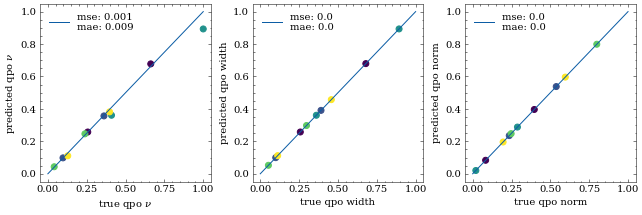

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(9,3))
fig.tight_layout()

colors = np.sort(2*list(range(len(predictions))))

ax = axs[0]
ax.scatter(test_freqs, predicted_freqs, c=colors)
ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')

ax = axs[1]
ax.scatter(test_widths, predicted_widths, c=colors)
ax.set(xlabel='true qpo width', ylabel='predicted qpo width')

ax = axs[2]
ax.scatter(test_norms, predicted_norms, c=colors)
ax.set(xlabel='true qpo norm', ylabel='predicted qpo norm')

for i in range(3):  
    ax = axs[i]
    mse = mses[i]
    mae = maes[i]
    line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
    ax.plot([0,1], [0,1], label=line_label)
    ax.legend()
    
plt.show()

## ridge

In [32]:
model = Ridge(alpha=0.1)

#wrapper = RegressorChain(model, order=[0,1])


model.fit(X=X_train, y=y_train)

predictions = model.predict(X_test)

print(predictions)

predicted_freqs = np.array([predictions[i][0:2] for i in range(len(predictions))])
predicted_widths = np.array([predictions[i][2:4] for i in range(len(predictions))])
predicted_norms = np.array([predictions[i][4:] for i in range(len(predictions))])

test_freqs = np.array([y_test[i][0:2] for i in range(len(y_test))])
test_widths = np.array([predictions[i][2:4] for i in range(len(y_test))])
test_norms = np.array([predictions[i][4:] for i in range(len(y_test))])

mses = [mse_score(test_freqs, predicted_freqs), mse_score(test_widths, predicted_widths), mse_score(test_norms, predicted_norms)]
maes = [mae_score(test_freqs, predicted_freqs), mae_score(test_widths, predicted_widths), mae_score(test_norms, predicted_norms)]

[[ 0.26221976  0.68666917  0.26192574  0.70190228  0.37336318  0.08902435]
 [ 0.10747994  0.3755355   0.10843152  0.41661878  0.54507447  0.18140989]
 [ 0.38387516  0.93686037  0.38085134  0.91239245  0.23763264 -0.00967258]
 [ 0.03322041  0.22640117  0.03745254  0.28479601  0.68050571  0.23631351]
 [ 0.12556384  0.4109638   0.13046341  0.46034906  0.59862356  0.19125868]]


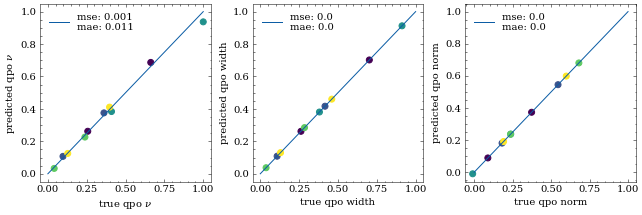

In [30]:
fig, axs = plt.subplots(1, 3, figsize=(9,3))
fig.tight_layout()

colors = np.sort(2*list(range(len(predictions))))

ax = axs[0]
ax.scatter(test_freqs, predicted_freqs, c=colors)
ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')

ax = axs[1]
ax.scatter(test_widths, predicted_widths, c=colors)
ax.set(xlabel='true qpo width', ylabel='predicted qpo width')

ax = axs[2]
ax.scatter(test_norms, predicted_norms, c=colors)
ax.set(xlabel='true qpo norm', ylabel='predicted qpo norm')

for i in range(3):  
    ax = axs[i]
    mse = mses[i]
    mae = maes[i]
    line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
    ax.plot([0,1], [0,1], label=line_label)
    ax.legend()
    
plt.show()

Feature: 0, Score: -0.03836
Feature: 1, Score: -0.13442
Feature: 2, Score: 0.06025
Feature: 3, Score: 0.11954
Feature: 4, Score: 0.06860


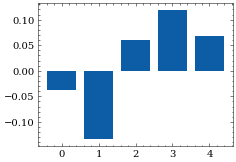

In [36]:
importance = model.coef_
# summarize feature importance
for i, v in enumerate(importance[0]):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
plt.bar([x for x in range(len(importance[0]))], importance[0])
plt.show()

## misc plots
* pairwise plots against fundamental properties 
## other to do
* test num qpo knn for this dataset

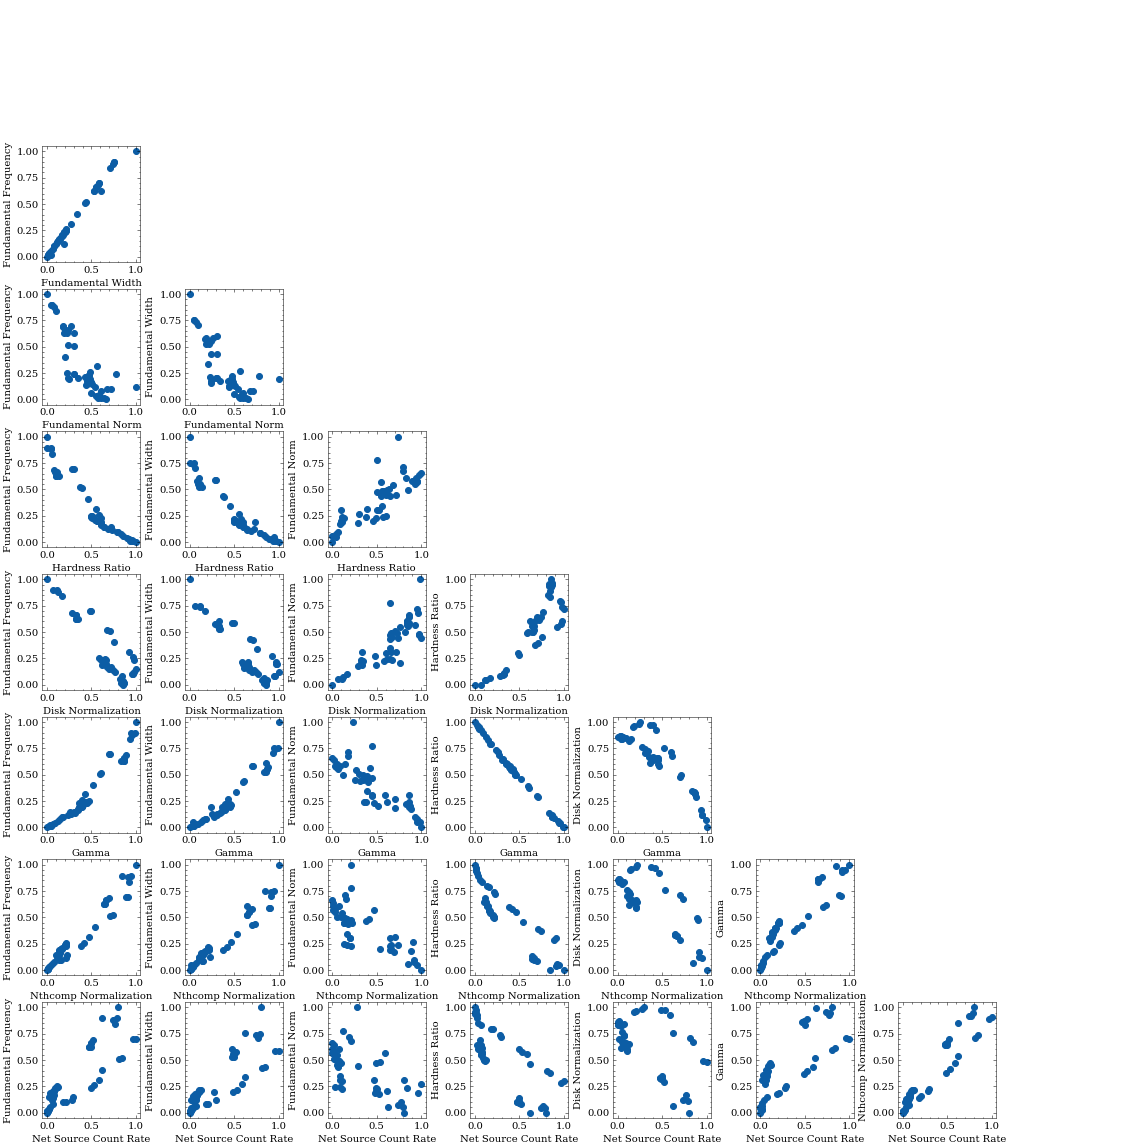

In [ ]:
keep_cols = ['first_freq', 'first_width', 'first_norm', 'hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error', 'nthcomp_norm_before_error', 'net_source_count_rate']
col_names = ['Fundamental Frequency', 'Fundamental Width', 'Fundamental Norm', 'Hardness Ratio', 'Disk Normalization', 'Gamma', 'Nthcomp Normalization', 'Net Source Count Rate']
pair_df = merged_df[keep_cols]

length = len(keep_cols)

fig, axs = plt.subplots(length, length, figsize=(2*length, 2*length))
fig.tight_layout()

for i in range(length): 
    for j in range(length): 
        if j>=i:
            ax = axs[i,j] 
            ax.axis('off')

        else: 
            ax = axs[i,j]
            ax.scatter(normalize(pair_df[keep_cols[i]]), normalize(pair_df[keep_cols[j]]))
            ax.set(xlabel=col_names[i], ylabel=col_names[j])

## feature importance 


In [12]:
throwaway = np.array([hardness, disk_norms, gammas, nthcomp_norms, net_source_counts])
print(throwaway.shape)
throwaway = throwaway.reshape(np.flip(throwaway.shape))

(5, 47)


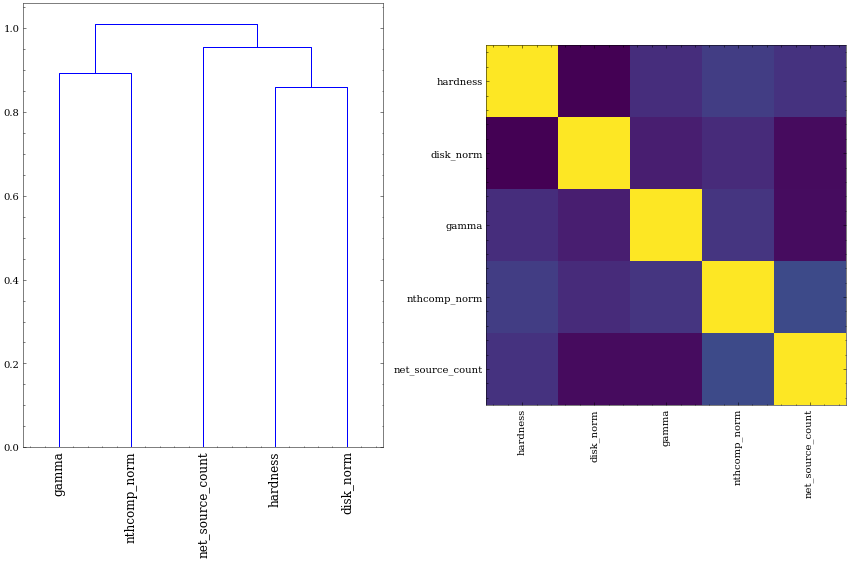

In [15]:
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(throwaway).correlation

names = ['hardness', 'disk_norm', 'gamma', 'nthcomp_norm', 'net_source_count']

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, ax=ax1, labels=names, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(names, rotation="vertical")
ax2.set_yticklabels(names)
fig.tight_layout()
plt.show()

## Classification testing

In [ ]:
full_df = qpo_df.merge(spectral_df, left_on='full_id', right_on='full_ids').sample(frac=1, random_state=rs)

full_df = full_df.iloc[np.where(full_df['num_qpos']!='flagged')]

keep_cols = ['num_qpos', 'hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error', 'nthcomp_norm_before_error', 'net_source_count_rate']
full_df = full_df[keep_cols]
for i in keep_cols: 
    full_df = full_df.astype({i:float})

In [ ]:
x_vals = np.array([], dtype=float).reshape(0,5) 
arr_names =  ['hardness_ratio', 'diskbb_norm_before_error', 'gamma_before_error', 'nthcomp_norm_before_error', 'net_source_count_rate'] #reduced_fit_stat
(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts) = (normalize(np.array(full_df[arr_name])) for arr_name in arr_names)

for a, b, c, d, e, in zip(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e)])
    x_vals = np.vstack([x_vals, new_arr])

num_qpos = np.array(full_df['num_qpos'])

num_qpos = np.reshape(num_qpos, (num_qpos.shape[0], 1)).astype(int)

X_train, X_test, y_train, y_test = train_test_split(x_vals, num_qpos, test_size=0.25, shuffle=True, random_state=rs)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

predictions = knn.predict(X_test)
acc = acc_score(y_test, predictions)
print(predictions)
acc

[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 2 0 0 0 0 0 2 2 0 0 2 0 0]


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


1.0

### MDS !!!

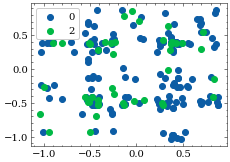

In [ ]:
from sklearn.manifold import MDS
from sklearn.decomposition import PCA, IncrementalPCA

test_zipped = list(zip(hardness, disk_norms, gammas, nthcomp_norms, net_source_counts))
x_df = pd.DataFrame(test_zipped)

num_qpos = np.array(full_df['num_qpos'])

mds = MDS(random_state=0)
transformed = mds.fit_transform(x_df)
transformed = np.reshape(transformed, np.flip(transformed.shape))
x_mds = transformed[0]
y_mds = transformed[1]

zero_mask = np.where(num_qpos==0)
two_mask = np.where(num_qpos==2)

plt.scatter(x_mds[zero_mask], y_mds[zero_mask], label='0')
plt.scatter(x_mds[two_mask], y_mds[two_mask], label='2')

plt.legend(frameon=True, framealpha=1)
plt.show()

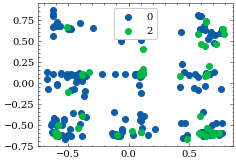

In [ ]:
pca = PCA(n_components=2)
transformed = pca.fit_transform(x_df)
transformed = np.reshape(transformed, np.flip(transformed.shape))
x_pca = transformed[0]
y_pca = transformed[1]

zero_mask = np.where(num_qpos==0)
two_mask = np.where(num_qpos==2)

plt.scatter(x_pca[zero_mask], y_pca[zero_mask], label='0')
plt.scatter(x_pca[two_mask], y_pca[two_mask], label='2')

plt.legend(frameon=True, framealpha=1)
plt.show()